In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
with open('/content/drive/MyDrive/TU/dex_WETHUSDT.pkl', 'rb') as f:
    dex = pickle.load(f)

with open('/content/drive/MyDrive/TU/ETHUSDT.pkl', 'rb') as f:
    cex = pickle.load(f)

merged = cex.merge(dex, left_index=True, right_index=True, suffixes=('_btc', '_uni'))

# **1. Calculating moving avarage**

In [3]:
merged['moving_avg_uni'] = merged['close_uni'].rolling(window=5).mean()
merged['moving_avg_btc'] = merged['close_btc'].rolling(window=5).mean()

# Min-Max Normalization
merged['moving_avg_btc_normalized'] = (merged['moving_avg_btc'] - merged['moving_avg_btc'].min()) / (merged['moving_avg_btc'].max() - merged['moving_avg_btc'].min())
merged['moving_avg_uni_normalized'] = (merged['moving_avg_uni'] - merged['moving_avg_uni'].min()) / (merged['moving_avg_uni'].max() - merged['moving_avg_uni'].min())

#merged = merged.resample('H').mean()
start_time = '2022-01-09 00:00:00'
end_time = '2022-01-10 23:59:59'
merged = merged.loc[start_time:end_time]

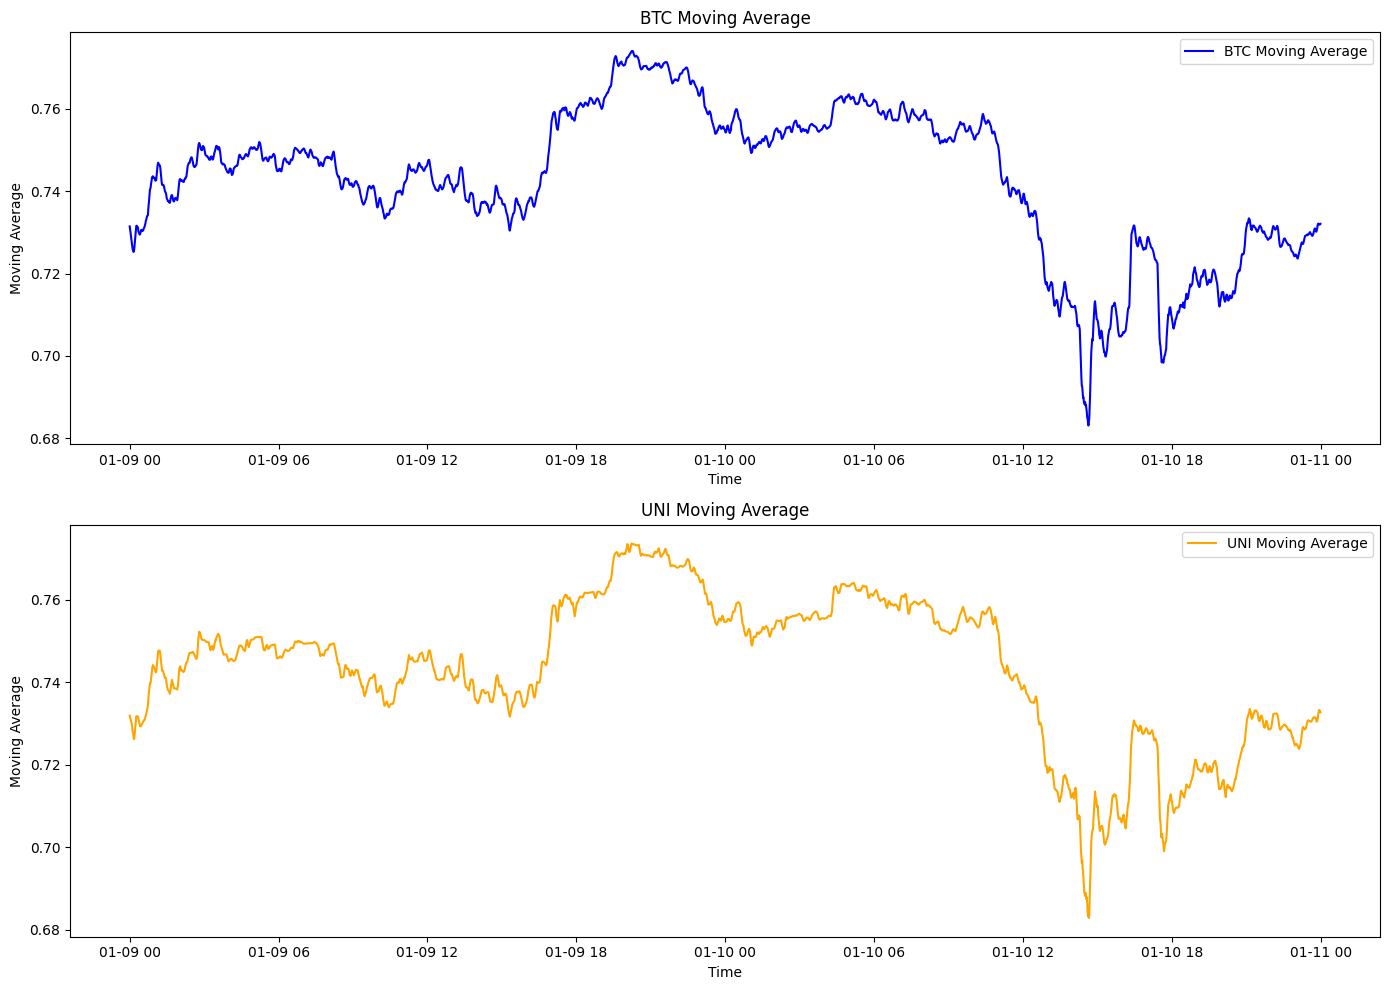

In [4]:
fig, axs = plt.subplots(2, figsize=(14, 10))
axs[0].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['moving_avg_btc_normalized'], label='BTC Moving Average', color='blue')
axs[1].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['moving_avg_uni_normalized'], label='UNI Moving Average', color='orange')
axs[0].set_title('BTC Moving Average')
axs[1].set_title('UNI Moving Average')
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Moving Average')
    ax.legend()

plt.tight_layout()
plt.show()

The movement from January 15th to April 1st seem to deviate from each other strongly with a suspisious difference in trends, highs and lows

# **2. Correlation coefficient of percentage change**

In [6]:
merged['pct_change_btc'] = merged['moving_avg_btc'].pct_change()
merged['pct_change_uni'] = merged['moving_avg_uni'].pct_change()

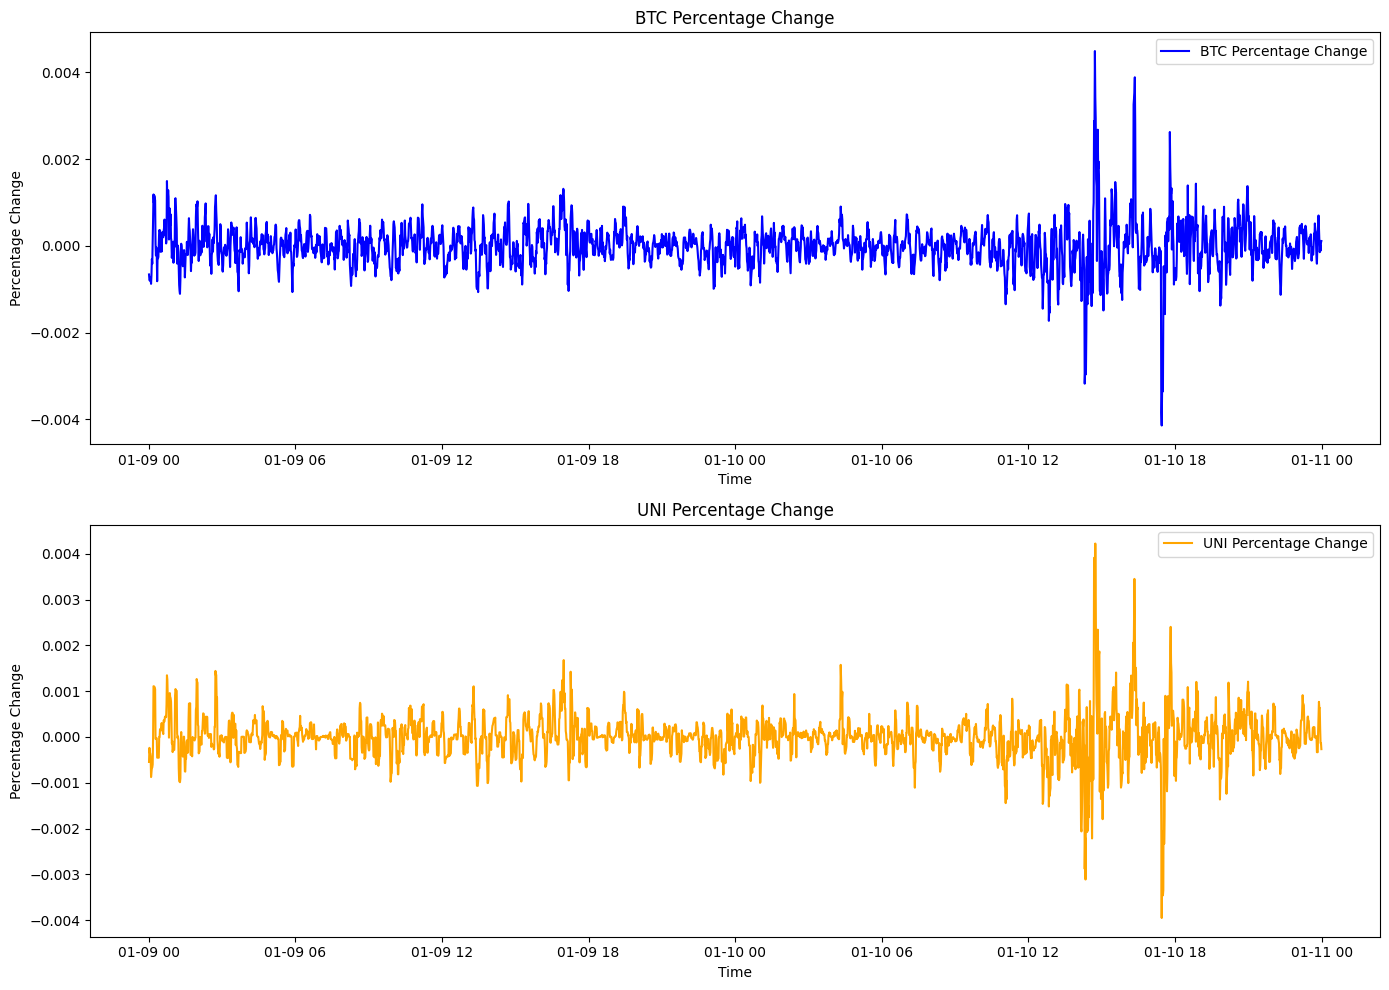

In [7]:
fig, axs = plt.subplots(2, figsize=(14, 10))
axs[0].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['pct_change_btc'], label='BTC Percentage Change', color='blue')
axs[1].plot(merged.loc[start_time:end_time].index, merged.loc[start_time:end_time]['pct_change_uni'], label='UNI Percentage Change', color='orange')
axs[0].set_title('BTC Percentage Change')
axs[1].set_title('UNI Percentage Change')
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Percentage Change')
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
def calculate_correlation(merged, start_date, end_date, timedelta):
    start_time = pd.to_datetime(start_date)
    end_time = pd.to_datetime(end_date)

    correlation_values = []
    current_time = start_time

    while current_time <= end_time:
        end_time_interval = current_time + pd.Timedelta(minutes=timedelta)
        
        correlation = merged.loc[current_time:end_time_interval, 'moving_avg_btc_normalized'].dropna().corr(merged.loc[current_time:end_time_interval, 'moving_avg_uni_normalized'].dropna())
        print(f'Correlation coefficient for period starting {current_time}:', correlation)
        
        correlation_values.append(correlation)
        current_time += pd.Timedelta(minutes=10)

    return correlation_values

### Correlation coefficient

In [11]:
correlation = merged['moving_avg_btc_normalized'].dropna().corr(merged['moving_avg_uni_normalized'].dropna())
print('Correlation coefficient:', correlation)

Correlation coefficient: 0.9985753348439876


In [16]:
coef = calculate_correlation(merged, start_time, end_time, 20)
# Funktioniert nur mit Daten über meherere Monate

Correlation coefficient for period starting 2022-01-09 00:00:00: 0.9429254716440695
Correlation coefficient for period starting 2022-01-09 00:10:00: 0.9433601793684881
Correlation coefficient for period starting 2022-01-09 00:20:00: 0.8196910936223885
Correlation coefficient for period starting 2022-01-09 00:30:00: 0.9937924668190775
Correlation coefficient for period starting 2022-01-09 00:40:00: 0.9914743493901854
Correlation coefficient for period starting 2022-01-09 00:50:00: 0.9705714056281497
Correlation coefficient for period starting 2022-01-09 01:00:00: 0.9388270154492573
Correlation coefficient for period starting 2022-01-09 01:10:00: 0.9981188815469169
Correlation coefficient for period starting 2022-01-09 01:20:00: 0.9840843169160516
Correlation coefficient for period starting 2022-01-09 01:30:00: 0.8607584467820912
Correlation coefficient for period starting 2022-01-09 01:40:00: 0.9279113895873286
Correlation coefficient for period starting 2022-01-09 01:50:00: 0.993153747

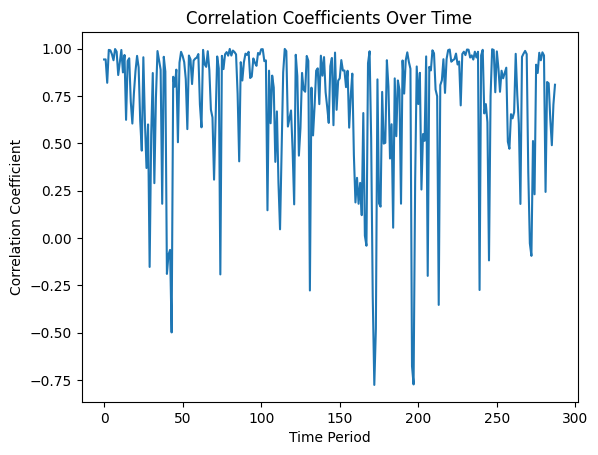

In [17]:
plt.plot(coef)
plt.title('Correlation Coefficients Over Time')
plt.xlabel('Time Period')
plt.ylabel('Correlation Coefficient')
plt.show()

# **3. Cross-Correlation**

Cross-correlation is a measure of similarity of two time series as a function of the displacement of one relative to the other. This is also known as a sliding dot product or sliding inner-product. It is commonly used for searching a long-duration signal for a shorter, known feature. 

In [31]:
start_time = '2022-01-09 00:00:00'
end_time = '2022-01-10 23:59:59'
focus_frame = merged.loc[start_time:end_time].copy()

In [32]:
import numpy as np

ts1 = focus_frame['moving_avg_btc_normalized'].dropna()
ts2 = focus_frame['moving_avg_uni_normalized'].dropna()
assert len(ts1) == len(ts2)

lags = np.arange(-len(ts1) + 1, len(ts1))
ccov = np.correlate(ts1, ts2, mode='full')
ccor = ccov / len(ts1)

print('Cross-correlation:', ccor)

Cross-correlation: [0.00018569 0.00037128 0.0005567  ... 0.00055651 0.00037112 0.00018564]


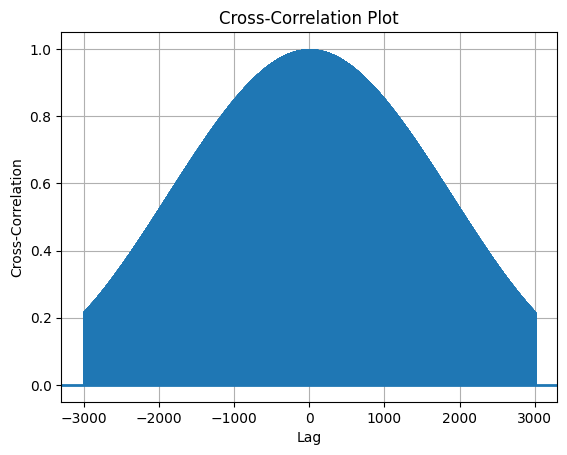

In [33]:
plt.xcorr(ccor, ccor, usevlines=True, maxlags=3000, normed=True, lw=2)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Plot')
plt.grid(True)
plt.show()

The bell shape indicates a symmetric correlation pattern between the two time series. The bell shape typically suggests a strong positive correlation at the center lag, gradually decreasing towards the edges. It means that there is a time delay or lag between the two series, resulting in a lagged correlation pattern. This shape is expected when the two series have a consistent and periodic relationship, such as seasonal or cyclical patterns.

# **4. Cointegration Test**

The p-value from the cointegration test tells the probability that the two series are not cointegrated. A small p-value (typically ≤ 0.05) indicates strong evidence that the series are cointegrated.

In [34]:
start_time = '2022-01-09 00:00:00'
end_time = '2022-01-10 23:59:59'
focus_frame = merged.loc[start_time:end_time].copy()

In [35]:
score, p_value, _ = coint(merged['moving_avg_btc_normalized'].dropna(), merged['moving_avg_uni_normalized'].dropna())
print('Cointegration test p-value:', p_value)

Cointegration test p-value: 1.972000928757883e-11
